# Test strategy
The strategy follows a mean reverting philosopy. It will buy a falling asset in proportion to the amount that it fell and it will sell with the opposite principle.

We are considering 5 minute data for eth, sol and btc. The strategy is always invested. In this example for semplicity we will close the entire position at the end of the candle and open a new one in the following one.

We will find that, as someone might have suspected, that the profit doesn't offset the fees paid, considering the huge volume traded.

I will test further to see if with the needed adjustments it is still an impractical strategy.

## Data
Import and format the data as needed.

In [117]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
eth = f'/Users/gabrielefabietti/projects/fetch_data/data/2023_data/ETHUSDT_5_data.csv'
btc = f'/Users/gabrielefabietti/projects/fetch_data/data/2023_data/BTCUSDT_5_data.csv'
sol = f'/Users/gabrielefabietti/projects/fetch_data/data/2023_data/SOLUSDT_5_data.csv'

df_eth = pd.read_csv(eth)
df_btc = pd.read_csv(btc)
df_sol = pd.read_csv(sol)

In [119]:
df_btc['pct_change_btc'] = (df_btc['close'] - df_btc['open']) / df_btc['open'] * 100
df_sol['pct_change_sol'] = (df_sol['close'] - df_sol['open']) / df_sol['open'] * 100
df_eth['pct_change_eth'] = (df_eth['close'] - df_eth['open']) / df_eth['open'] * 100

In [120]:
df_btc = df_btc.set_index('timestamp')
df_eth = df_eth.set_index('timestamp')
df_sol = df_sol.set_index('timestamp')

In [121]:
combined_df = df_btc['close'].to_frame(name='btc_close')
combined_df = combined_df.join(df_eth['close'].rename('eth_close'))
combined_df = combined_df.join(df_sol['close'].rename('sol_close'))

combined_df.head()

,btc_close,eth_close,sol_close
timestamp,,,
1672527600000,16522.0,1195.50,9.925
1672527900000,16508.0,1194.85,9.890
1672528200000,16517.0,1196.20,9.940
1672528500000,16541.0,1196.80,9.975
1672528800000,16544.0,1196.35,9.975


In [122]:
combined_df = combined_df.join(df_btc['pct_change_btc'])
combined_df = combined_df.join(df_sol['pct_change_sol'])
combined_df = combined_df.join(df_eth['pct_change_eth'])

combined_df.info()
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 105121 entries, 1672527600000 to 1704063600000
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   btc_close       105121 non-null  float64
 1   eth_close       105121 non-null  float64
 2   sol_close       105121 non-null  float64
 3   pct_change_btc  105121 non-null  float64
 4   pct_change_sol  105121 non-null  float64
 5   pct_change_eth  105121 non-null  float64
dtypes: float64(6)
memory usage: 5.6 MB


,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth
timestamp,,,,,,
1672527600000,16522.0,1195.50,9.925,-0.081643,-0.150905,-0.121141
1672527900000,16508.0,1194.85,9.890,-0.084736,-0.352645,-0.054371
1672528200000,16517.0,1196.20,9.940,0.054519,0.505561,0.112985
1672528500000,16541.0,1196.80,9.975,0.145305,0.352113,0.050159
1672528800000,16544.0,1196.35,9.975,0.018137,0.000000,-0.037600


## Strategy

After manipulating the data, we are ready to test the strategy. 

In [123]:
combined_df['btc_exp'] = combined_df['pct_change_btc'].shift(1) * (-1) * 100
combined_df['eth_exp'] = combined_df['pct_change_eth'].shift(1) * (-1) * 100
combined_df['sol_exp'] = combined_df['pct_change_sol'].shift(1) * (-1) * 100

combined_df['tot_exp'] = combined_df['btc_exp'] + combined_df['eth_exp'] + combined_df['sol_exp']

# 100 has to be modified to a number that makes sense considering the account size

In [124]:
combined_df['btc_pnl'] = combined_df['btc_exp'] * combined_df['pct_change_btc'] /100
combined_df['eth_pnl'] = combined_df['eth_exp'] * combined_df['pct_change_eth'] /100
combined_df['sol_pnl'] = combined_df['sol_exp'] * combined_df['pct_change_sol'] /100

In [125]:
stats_exp = combined_df['tot_exp'].describe()
print(stats_exp)

count    105120.000000
mean         -0.444389
std          55.318761
min       -2126.396962
25%         -23.339665
50%          -0.192778
75%          22.628594
max        3632.622142
Name: tot_exp, dtype: float64


In [126]:
tot_volume = combined_df['tot_exp'].abs().sum() * 2
fees = tot_volume * 0.035 /100

In [127]:
pnl_sol = combined_df['sol_pnl'].sum()
pnl_btc = combined_df['btc_pnl'].sum()
pnl_eth = combined_df['eth_pnl'].sum()

combined_df['tot_pnl'] = combined_df['btc_pnl'] + combined_df['eth_pnl'] + combined_df['sol_pnl']
final_pnl = combined_df['tot_pnl'].sum()

combined_df['account_pnl'] = combined_df['tot_pnl'].cumsum()

## Results
As we can see from the equity curve, the concept seems promising. Upon further inspection we realize that the strategy is not very good. Having to modify the allocation every 5 minutes is expensive. Also the profit isnt necessarily exceptional considering the capital neeeded to consider this approch somewhat safe.

It is important to remind that this is the worst the strategy can be. 

In [128]:
print("PnL summary")
print(f"SOL: {pnl_sol}")
print(f"ETH: {pnl_eth}")
print(f"BTC: {pnl_btc}")

print(f"TOTAL: {final_pnl}")

print(f"total traded volume: {tot_volume}")

print(f"estimated taker fees: {fees}")

PnL summary
SOL: 601.4582475211135
ETH: 174.69132559310853
BTC: 128.31830650221247
TOTAL: 904.4678796164345
total traded volume: 7146163.286024336
estimated taker fees: 2501.1571501085177


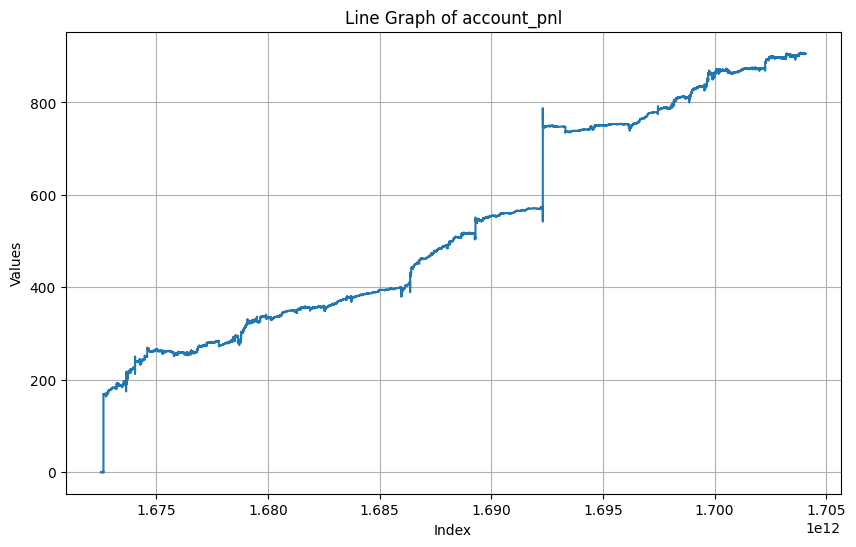

In [129]:
# Create a simple line plot
plt.figure(figsize=(10, 6))
plt.plot(combined_df['account_pnl'])
plt.title('Line Graph of account_pnl')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [130]:
# This gives you count, mean, std, min, 25%, 50%, 75%, max
print("pnl statistics:")
stats = combined_df['tot_pnl'].describe()
print(stats)

print("exposure statistics:")
stats_exp = combined_df['tot_exp'].describe()
print(stats_exp)

pnl statistics:
count    105120.000000
mean          0.008604
std           1.004776
min         -38.650895
25%          -0.016353
50%           0.000856
75%           0.022522
max         245.366856
Name: tot_pnl, dtype: float64
exposure statistics:
count    105120.000000
mean         -0.444389
std          55.318761
min       -2126.396962
25%         -23.339665
50%          -0.192778
75%          22.628594
max        3632.622142
Name: tot_exp, dtype: float64


## More
Added some visualizing tools to isolate interesting data.

In [131]:
pnl_sorted_df = combined_df.sort_values('tot_pnl', ascending=False)
pnl_sorted_df.head(25)

,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth,btc_exp,eth_exp,sol_exp,tot_exp,btc_pnl,eth_pnl,sol_pnl,tot_pnl,account_pnl
timestamp,,,,,,,,,,,,,,,
1692308700000,25609.9,1590.21,21.024,5.643994,5.967742,8.309438,1207.154205,1387.433787,1038.034149,3632.622142,68.131706,115.287951,61.947199,245.366856,787.815703
1672643700000,16723.0,1214.10,10.950,0.149719,-8.635795,0.513288,-32.142750,-50.339061,-1979.010495,-2061.492305,-0.048124,-0.258384,170.903284,170.596777,169.503859
1673656800000,21068.0,1562.70,20.080,-0.042701,-3.368624,-0.430087,-329.331046,-612.997025,-1184.068891,-2126.396962,0.140626,2.636420,39.886825,42.663872,217.238137
1686371100000,25844.0,1793.82,13.894,-0.112858,2.622055,-0.405856,153.295783,128.143995,1633.813261,1915.253039,-0.173007,-0.520081,42.839479,42.146392,431.569748
1674057300000,21025.0,1548.75,21.770,0.948266,3.790226,1.064975,171.766982,217.865897,739.514349,1129.147228,1.628807,2.320218,28.029269,31.978293,244.414248
1689295800000,31379.9,2015.52,29.766,-0.305945,-2.476902,-0.279541,-1.525194,4.055411,-1269.800244,-1267.270027,0.004666,-0.011337,31.451706,31.445036,551.223447
1702260900000,42051.6,2238.64,68.765,0.712022,1.580619,1.641324,234.716859,484.113474,597.394300,1316.224633,1.671237,7.945871,9.442528,19.059636,887.788672
1697463000000,29236.2,1619.29,23.987,-0.910360,-2.309196,-0.369778,-538.745915,-231.471864,-491.368997,-1261.586775,4.904529,0.855932,11.346674,17.107134,792.027261
1685981100000,25754.7,1807.03,20.032,0.936283,3.792746,1.390377,180.565711,203.111258,305.891808,689.568776,1.690605,2.824013,11.601700,16.116318,395.867753


In [132]:
# print the dataframe section around a specific timestamp (index)

target_timestamp = 1692308700000

# Get the position of the timestamp in the index
idx_position = combined_df.index.get_loc(target_timestamp)

# Calculate the start and end positions
start_position = max(0, idx_position - 5)
end_position = min(len(combined_df), idx_position + 6)  # +6 because we want 5 rows after the target

# Get the rows
result = combined_df.iloc[start_position:end_position]
display(result)

,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth,btc_exp,eth_exp,sol_exp,tot_exp,btc_pnl,eth_pnl,sol_pnl,tot_pnl,account_pnl
timestamp,,,,,,,,,,,,,,,
1692307200000,27700.0,1719.61,22.655,0.111677,0.278860,0.073909,-28.633459,-35.801683,-12.409147,-76.844290,-0.031977,-0.026461,-0.034604,-0.093042,574.709668
1692307500000,27669.0,1716.00,22.516,-0.111913,-0.613551,-0.209931,-11.167692,-7.390854,-27.885977,-46.444524,0.012498,0.015516,0.171095,0.199109,574.908777
1692307800000,27704.5,1717.66,22.485,0.128302,-0.137680,0.096737,11.191336,20.993132,61.355109,93.539577,0.014359,0.020308,-0.084474,-0.049807,574.858970
1692308100000,27569.8,1704.73,22.138,-0.486203,-1.543251,-0.752768,-12.830243,-9.673660,13.767987,-8.735916,0.062381,0.072820,-0.212475,-0.077273,574.781697
1692308400000,24241.7,1468.21,19.840,-12.071542,-10.380341,-13.874338,48.620260,75.276830,154.325106,278.222196,-5.869215,-10.444162,-16.019473,-32.332850,542.448847
1692308700000,25609.9,1590.21,21.024,5.643994,5.967742,8.309438,1207.154205,1387.433787,1038.034149,3632.622142,68.131706,115.287951,61.947199,245.366856,787.815703
1692309000000,26212.8,1619.52,21.378,2.354168,1.683790,1.843153,-564.399361,-830.943802,-596.774194,-1992.117357,-13.286908,-15.315564,-10.048424,-38.650895,749.164808
1692309300000,26230.8,1618.10,21.250,0.068669,-0.598746,-0.087680,-235.416772,-184.315279,-168.378995,-588.111047,-0.161658,0.161608,1.008163,1.008114,750.172921
1692309600000,26277.2,1618.89,21.227,0.176891,-0.108235,0.048823,-6.866874,8.768030,59.874637,61.775793,-0.012147,0.004281,-0.064805,-0.072672,750.100250


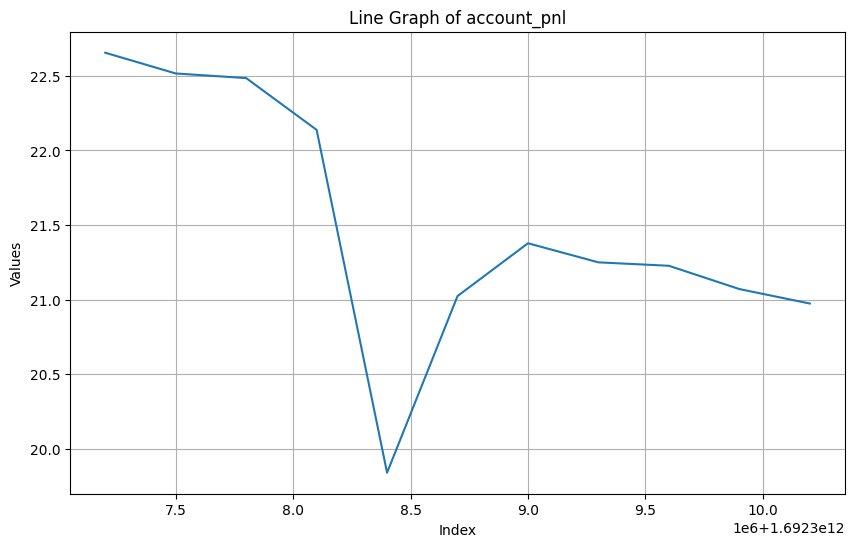

In [133]:
# Create a simple line plot
plt.figure(figsize=(10, 6))
plt.plot(result['sol_close'])
plt.title('Line Graph of account_pnl')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.show()